## Training - Guideline

This notebook was designed with the purpose of guiding you with the development of your first Training Job

There are many functions and methods that we provide you in the melitk.analytics library (which comes pre-installed), but will not appear in this demo. The general idea behind this demo is for you to understand how the Fury Data Apps expects your Training process in order to run successfully and generate the model (and eventually metrics) you expect

### Example

Here we will read the dataset that we generated in the demo etl/etl.ipynb and train a Sklearn Decission Tree model to predict the probability of some users of recharging their cellphones

## Imports

In [46]:

import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from lifetimes.utils import summary_data_from_transaction_data
import numpy as np
import datetime
from multiprocessing import Pool, cpu_count
from tqdm import tqdm
from lifetimes import ModifiedBetaGeoFitter
from lifetimes import GammaGammaFitter
import dask.dataframe as dd
from dask.multiprocessing import get
from collections import Counter
from sklearn.model_selection import train_test_split
import gc
import joblib
import boto3
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from sklearn.utils import class_weight
from sklearn.model_selection import RandomizedSearchCV, KFold
import numpy as np
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score
import joblib
import os
from sklearn.metrics import confusion_matrix
import seaborn as sns
from bayes_opt import BayesianOptimization
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import average_precision_score
from sklearn.preprocessing import label_binarize
import pickle
from sklearn.utils import class_weight
from sklearn.metrics import f1_score

os.write(1,b'\n starting')
debug = False

In [2]:
def _write_dataframe_to_csv_on_s3(df, path_s3):
    import boto3
    from io import StringIO
    """ Write a dataframe to a CSV on S3 """
    a = path_s3.split('//')
    b = a[1].split('/')
    bucket = b[0]
    c = path_s3.split(bucket+'/')
    path = c[1]
    
    buffer = StringIO()
    df.to_csv(buffer,index=False)
    s3_resource = boto3.resource('s3')
    s3_resource.Object(bucket, path).put(Body=buffer.getvalue())
    return None

In [3]:
def asigno_quintiles_6(x):
    step = int(x.shape[0]*0.1) # segmentos de 10%
    
    l_ = []
    for i in range(6):  # asigno los primeros 50% en segmentos de 10%
        l_ = l_ + ["q"+str(i+1)]*step    
    
    step2 = x.shape[0] - len(l_)
    l_ = l_ + ["q6"]*step2
    return l_

In [21]:
def print_s3(x,s3_path):
    import boto3
    import datetime
    
    print(x)
    file = s3_path.split('/')[-1]
    with open(file, "a") as myfile:
        myfile.write(str(datetime.date.today().strftime("%m/%d/%Y %H:%M:%S") + ": "+x + "\n"))
        
    s3 = boto3.client('s3')
    s3.upload_file(file, "fda-labs",  '/'.join(s3_path.split('/')[3:])) 

In [5]:
#!aws s3 cp s3://fda-labs/ltv-ml/Lightgbm/log.txt file.txt

## Initial Setup

## Reading the dataset

Load the dataset (that was saved in the ETL script) and split it into train and test sets.

In [6]:
if(debug == False):
    cores = cpu_count()
    n_iter = 20
else:
    cores = 4
    n_iter = 2

In [22]:
print_s3("Empezado","s3://fda-labs/ltv-ml/lgbm_embedding/log.txt")  
if(debug == False):
    summary_cal = pd.read_csv('s3://fda-labs/ltv-ml/ML/preproc_data_train.csv.gzip')  # Because in the ETL we pickled the pandas dataframe
else:
    summary_cal = pd.read_csv('s3://fda-labs/ltv-ml/ML/sample_Preproc_MLA.csv')  # Because in the ETL we pickled the pandas dataframe
    
doc2vec_visits = pd.read_csv('s3://fda-labs/ltv-ml/Embedding/preproc_Doc2vec/train_doc2vec_20_20.csv')
summary_cal = pd.merge(summary_cal,doc2vec_visits,on="cust",how = "left")
cols_visits = [x for x in doc2vec_visits.columns if(x not in 'cust')]
summary_cal[cols_visits] = summary_cal[cols_visits].fillna(0)

Empezado


In [23]:
print_s3("----------------------------------------------------------------------------",
         "s3://fda-labs/ltv-ml/Lightgbm/log.txt")  
print_s3("Leyo train","s3://fda-labs/ltv-ml/lgbm_embedding/log.txt")  

if(debug == False):
    train = summary_cal.sample(frac = 1.,random_state=20)
else:
    train = summary_cal.sample(frac = 0.025,random_state=20)

----------------------------------------------------------------------------
Leyo train


In [24]:
train_cols = [ 'frequency', 'recency', 'T', 'monetary_value', 'my_recency', 'n_purchases_pred', 'p_alive',
                       'montary_sales_forecast', 'clv_pareto', 'target_pareto','IPT_CV', 'money_sum',
                       'money_CV', 'money_mean', 'money_std', 'money_max', 'money_min',
                       'L1_1000', 'L1_1039', 'L1_1051', 'L1_1071', 'L1_1132', 'L1_1144',
                       'L1_1168', 'L1_1182', 'L1_1246', 'L1_1276', 'L1_1367', 'L1_1368',
                       'L1_1384', 'L1_1403', 'L1_1430', 'L1_1499', 'L1_1574', 'L1_1648',
                       'L1_1798', 'L1_1953', 'L1_2547', 'L1_3025', 'L1_3937', 'L1_407134',
                       'L1_409431', 'L1_5725', 'L1_5726', 'female', 'male', 'Account Money',
                       'Bank Transfer', 'Credit Card', 'Debit Card', 'Ticket',
                       'digital_currency', '01.Menor de 18 años', '02.Entre 18 y 25 años',
                       '03.Entre 26 y 30 años', '04.Entre 31 y 35 años',
                       '05.Entre 36 y 40 años', '06.Entre 41 y 55 años',
                       '07.Entre 56 y 65 años', '08.Mayor de 65 años']
train_cols = train_cols + cols_visits

In [33]:
weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(summary_cal.quintil_true), summary_cal.quintil_true)

weights = dict(zip(list(range(len(weights))), weights))
summary_cal= summary_cal.replace({"quintil_true":{"q1":0,"q2":1,"q3":2,"q4":3,"q5":4,"q6":5}})
train = summary_cal
stdc = StandardScaler()
stdc_trained = stdc.fit(train[train_cols])

def lgb_evaluate(    
                learning_rate,
                num_leaves,                
                max_depth,
                lambda_l2,
                lambda_l1,
                min_child_weight,
                colsample_bytree,
                subsample,
                min_data_in_leaf
                ):
    
    params = {
        "objective" :'multiclass',
       'boosting': "gbdt",
       'num_class': 6,
       'class_weight': weights,
       'metric':'multi_logloss',
       'reg_alpha': lambda_l1,
       'reg_lambda': lambda_l2,
       'min_split_gain': 0,
       'subsample_freq': 3,
       'subsample_for_bin': 50000,
       'n_estimators': 2000,
       'num_leaves': int(num_leaves),
       'max_depth': int(max_depth),
       'min_child_weight': min_child_weight,
       'subsample': subsample,
       'colsample_bytree': colsample_bytree,
       'learning_rate': learning_rate,
       'min_data_in_leaf': int(round(min_data_in_leaf)),
        'n_jobs': cores,
       'verbose':-1,
       'random_state': 45
    }

    train, valid= train_test_split(summary_cal,test_size=0.25,random_state=0)
    X_train =  stdc_trained.transform(train[train_cols])
    X_valid =  stdc_trained.transform(valid[train_cols])
    y_train =  train.quintil_true
    y_valid =  valid.quintil_true
    
#     lgb_train = lgb.Dataset(X_train, y_train)
#     lgb_eval = lgb.Dataset(X_valid, y_valid, reference=lgb_train)

    gbm = lgb.LGBMClassifier(**params)
    gbm.fit(X=X_train, y=y_train, eval_set=(X_valid, y_valid), early_stopping_rounds=15,verbose=100)
    
    
    
#     train(params, lgb_train, 5000, valid_sets=[lgb_train, lgb_eval], \
#                     valid_names = ['train', 'valid'], \
#                     early_stopping_rounds=15, verbose_eval=100, 
#                     categorical_feature='auto')

    y_pred = gbm.predict_proba(X_valid)
    resu = average_precision_score(label_binarize(y_valid,[0,1,2,3,4,5]),y_pred)
#     resu = average_precision_score(y_valid,y_pred)
#     resu = average_precision_score(label_binarize(y_valid,[0,1,2,3,4,5]),label_binarize(y_pred,[0,1,2,3,4,5]))
 
    print_s3("parametros: "+str(params),"s3://fda-labs/ltv-ml/lgbm_embedding/log.txt")  
    print_s3("resu: "+str(resu),"s3://fda-labs/ltv-ml/lgbm_embedding/log.txt") 
    
    return resu
   
def bayesOpt(train_x, train_y):
    lgbBO = BayesianOptimization(lgb_evaluate, { 
                                                'learning_rate':(0.01, 0.50),
                                                'num_leaves': (10, 45),                                                
                                                'max_depth': (5, 8.99),                                                
                                                'lambda_l2': (0, 1000),
                                                'lambda_l1': (0, 1000),
                                                'min_child_weight': (5, 50),
                                                'colsample_bytree' : (0.7,1.0),
                                                'subsample' : (0.7,1.0),
                                                'min_data_in_leaf':(10,100)
                                            })

                
    lgbBO.maximize(init_points=8, n_iter=n_iter)
    return lgbBO
    try:
        print(lgbBO.res['max'])
    except:
        print("Non resu")
    
values = bayesOpt(1, 2)

|   iter    |  target   | colsam... | lambda_l1 | lambda_l2 | learni... | max_depth | min_ch... | min_da... | num_le... | subsample |
-------------------------------------------------------------------------------------------------------------------------------------
Training until validation scores don't improve for 15 rounds.
Early stopping, best iteration is:
[76]	valid_0's multi_logloss: 0.94416
parametros: {'objective': 'multiclass', 'min_data_in_leaf': 15, 'boosting': 'gbdt', 'n_estimators': 2000, 'verbose': -1, 'num_class': 6, 'subsample_freq': 3, 'metric': 'multi_logloss', 'n_jobs': 4, 'reg_alpha': 666.500159489695, 'num_leaves': 25, 'colsample_bytree': 0.7906959157821749, 'subsample': 0.888353707413909, 'min_split_gain': 0, 'subsample_for_bin': 50000, 'max_depth': 7, 'min_child_weight': 9.525152014128778, 'class_weight': {0: 1.6666797140024008, 1: 1.6666797140024008, 2: 1.6666797140024008, 3: 1.6666797140024008, 4: 1.6666797140024008, 5: 0.33333072390704177}, 'reg_lambda': 841

In [35]:
print_s3("Termina seleccion de hiperparametros","s3://fda-labs/ltv-ml/lgbm_embedding/log.txt")  

_write_dataframe_to_csv_on_s3(pd.DataFrame(values.res),"s3://fda-labs/ltv-ml/lgbm_embedding/ModelPerformance.csv") 

Termina seleccion de hiperparametros


In [34]:
aux = values.max["params"]

params = {
        "objective" :'multiclass',
       'boosting': "gbdt",
       'num_class': 6,
       'class_weight': weights,
       'metric':'multi_logloss',
       'reg_lambda': aux["lambda_l1"],
       'reg_lambda': aux["lambda_l2"],
       #'bagging_fraction': bagging_fraction,
       'min_split_gain': 0,
       #'min_child_samples': min_child_samples,
       'subsample_freq': 3,
       'subsample_for_bin': 50000,
       'n_estimators': 2000,
       'num_leaves': int(aux["num_leaves"]),
       'max_depth': int(aux["max_depth"]),
       'min_child_weight': aux["min_child_weight"],
       'subsample': aux["subsample"],
       'colsample_bytree': aux["colsample_bytree"],
       'learning_rate': aux["learning_rate"],
       'min_data_in_leaf': int(round(aux["min_data_in_leaf"])),
        'n_jobs': cores,
       'verbose':-1,
       'random_state': 45
    }

train, valid= train_test_split(summary_cal,test_size=0.25,random_state=0)
X_train =  stdc_trained.transform(train[train_cols])
X_valid =  stdc_trained.transform(valid[train_cols])
y_train =  train.quintil_true
y_valid =  valid.quintil_true

# lgb_train = lgb.Dataset(X_train, y_train)
# lgb_eval = lgb.Dataset(X_valid, y_valid, reference=lgb_train)

# gbm = lgb.train(params, lgb_train, 5000, valid_sets=[lgb_train, lgb_eval], \
#                 valid_names = ['train', 'valid'], \
#                 early_stopping_rounds=15, verbose_eval=100, 
#                 categorical_feature='auto')

gbm = lgb.LGBMClassifier(**params)
gbm.fit(X=X_train, y=y_train, eval_set=(X_valid, y_valid), early_stopping_rounds=15,verbose=100)
    
with open('model.pkl', 'wb') as fout:
    pickle.dump(gbm, fout)

s3 = boto3.client('s3')
s3.upload_file("model.pkl", "fda-labs", "ltv-ml/lgbm_embedding/model.pkl")

joblib.dump(stdc_trained,"std.sav")
s3.upload_file("std.sav", "fda-labs", "ltv-ml/lgbm_embedding/std.sav")

Early stopping, best iteration is:
[84]	valid_0's multi_logloss: 0.888432


In [36]:
print_s3("Guardo modelo","s3://fda-labs/ltv-ml/lgbm_embedding/log.txt")  

aux = values.max["params"]

params = {
        "objective" :'multiclass',
       'boosting': "gbdt",
       'num_class': 6,
       'class_weight': weights,
       'metric':'multi_logloss',
       'reg_lambda': aux["lambda_l1"],
       'reg_lambda': aux["lambda_l2"],
       'min_split_gain': 0,
       'subsample_freq': 3,
       'subsample_for_bin': 50000,
       'n_estimators': 2000,
       'num_leaves': int(aux["num_leaves"]),
       'max_depth': int(aux["max_depth"]),
       'min_child_weight': aux["min_child_weight"],
       'subsample': aux["subsample"],
       'colsample_bytree': aux["colsample_bytree"],
       'learning_rate': aux["learning_rate"],
       'min_data_in_leaf': int(round(aux["min_data_in_leaf"])),
        'n_jobs': cores,
       'verbose':-1,
       'random_state': 45
    }

train, valid= train_test_split(summary_cal,test_size=0.25,random_state=0)

X_train =  stdc_trained.transform(train[train_cols])
X_valid =  stdc_trained.transform(valid[train_cols])

X_train = np.c_[ X_train,  np.random.normal(size=train.shape[0]) ] 
X_valid = np.c_[ X_valid,  np.random.normal(size=valid.shape[0]) ] 

y_train =  train.quintil_true
y_valid =  valid.quintil_true

# lgb_train = lgb.Dataset(X_train, y_train)
# lgb_eval = lgb.Dataset(X_valid, y_valid, reference=lgb_train)

gbm = lgb.LGBMClassifier(**params)
gbm.fit(X=X_train, y=y_train, eval_set=(X_valid, y_valid), early_stopping_rounds=15,verbose=100)

Guardo modelo
Training until validation scores don't improve for 15 rounds.
[100]	valid_0's multi_logloss: 0.889136
Early stopping, best iteration is:
[126]	valid_0's multi_logloss: 0.887131


LGBMClassifier(boosting='gbdt', boosting_type='gbdt',
               class_weight={0: 1.6666797140024008, 1: 1.6666797140024008,
                             2: 1.6666797140024008, 3: 1.6666797140024008,
                             4: 1.6666797140024008, 5: 0.33333072390704177},
               colsample_bytree=0.9497506029362532, importance_type='split',
               learning_rate=0.44991260056893, max_depth=5,
               metric='multi_logloss', min_child_samples=20,
               min_child_weight=6.295585788561233, min_data_in_leaf=11,
               min_split_gain=0, n_estimators=2000, n_jobs=4, num_class=6,
               num_leaves=35, objective='multiclass', random_state=45,
               reg_alpha=0.0, reg_lambda=823.5225241167253, silent=True,
               subsample=0.8955818910768006, subsample_for_bin=50000,
               subsample_freq=3, verbose=-1)

Modelo con variable random entrenado


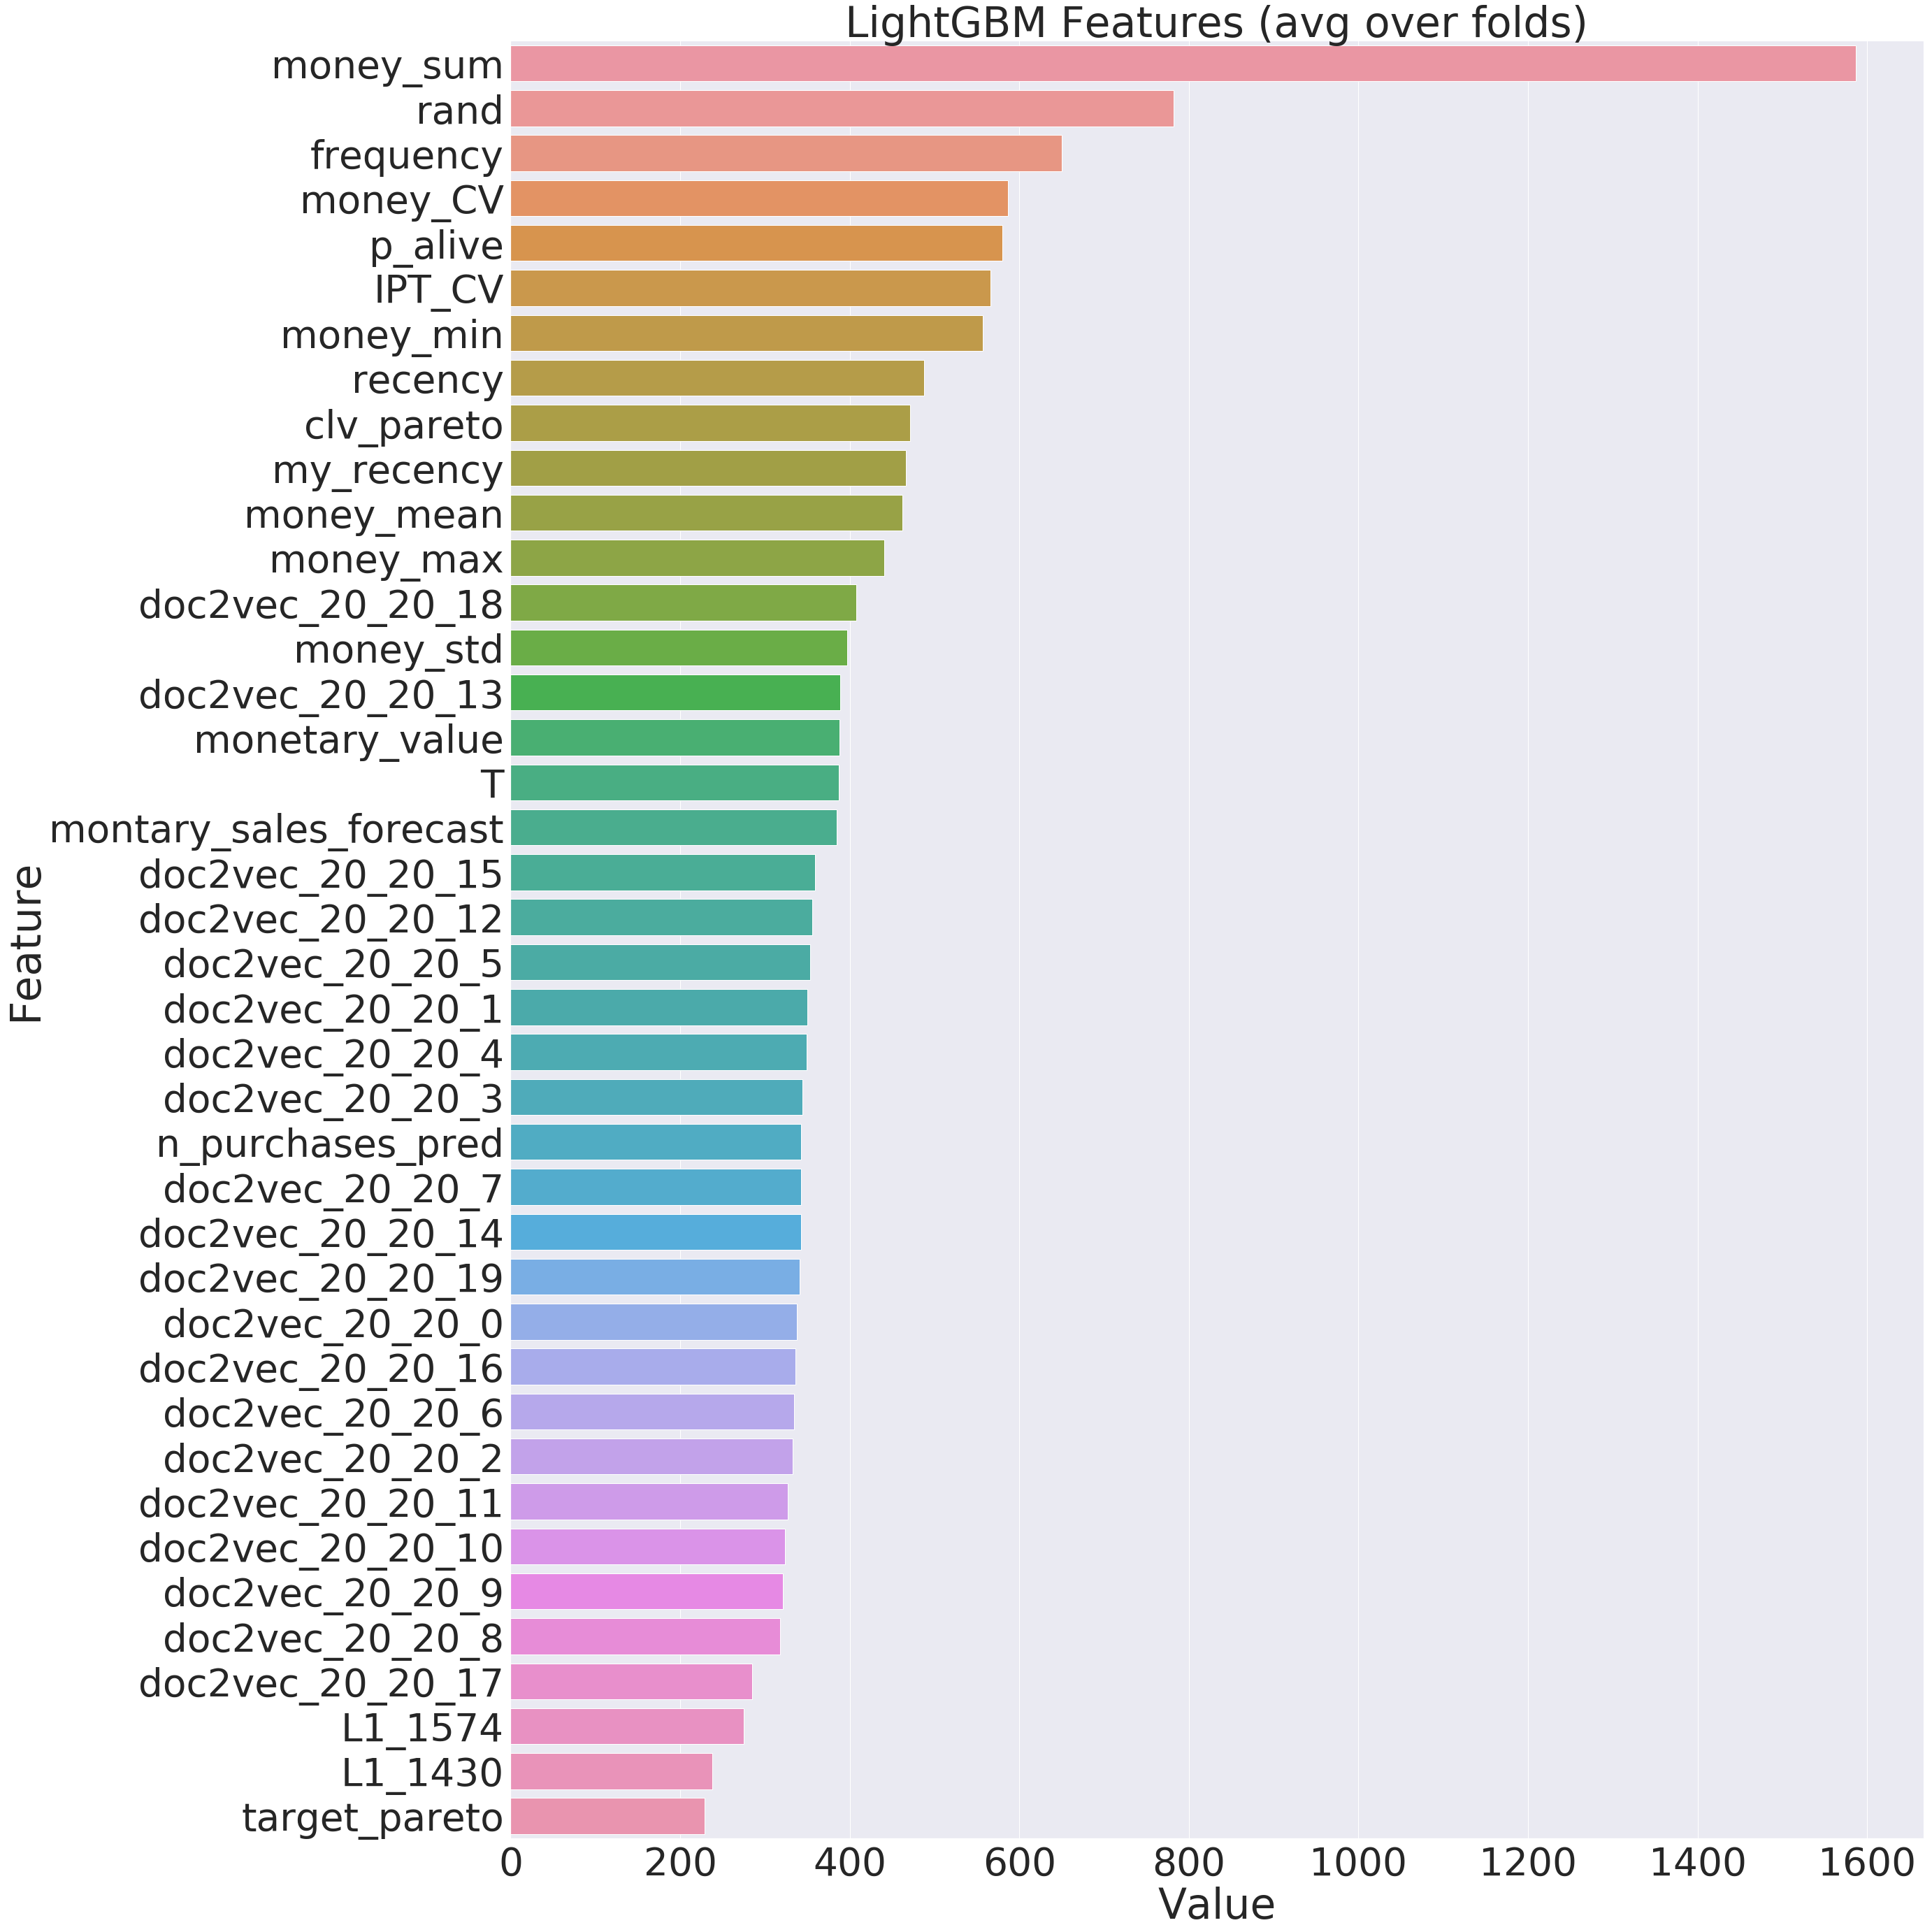

<Figure size 432x288 with 0 Axes>

In [37]:
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

print_s3("Modelo con variable random entrenado","s3://fda-labs/ltv-ml/lgbm_embedding/log.txt")  

feature_imp = pd.DataFrame(sorted(zip(gbm.feature_importances_,train_cols + ["rand"])), 
                           columns=['Value','Feature'])

plt.figure(figsize=(40, 40))
sns.set(font_scale = 5)
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", 
                                                    ascending=False)[0:40])
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.show()
plt.savefig('lgbmImportance.png')

s3 = boto3.client('s3')
s3.upload_file("lgbmImportance.png", "fda-labs", "ltv-ml/lgbm_embedding/lgbmImportance.png")
    

In [39]:
summary_cal = pd.read_csv('s3://fda-labs/ltv-ml/ML/preproc_data_test.csv.gzip') 
doc2vec_visits = pd.read_csv('s3://fda-labs/ltv-ml/Embedding/preproc_Doc2vec/test_doc2vec_20_20.csv')
summary_cal = pd.merge(summary_cal,doc2vec_visits,on="cust",how = "left")
cols_visits = [x for x in doc2vec_visits.columns if(x not in 'cust')]
summary_cal[cols_visits] = summary_cal[cols_visits].fillna(0)

Leyo test
Aplico sobre test


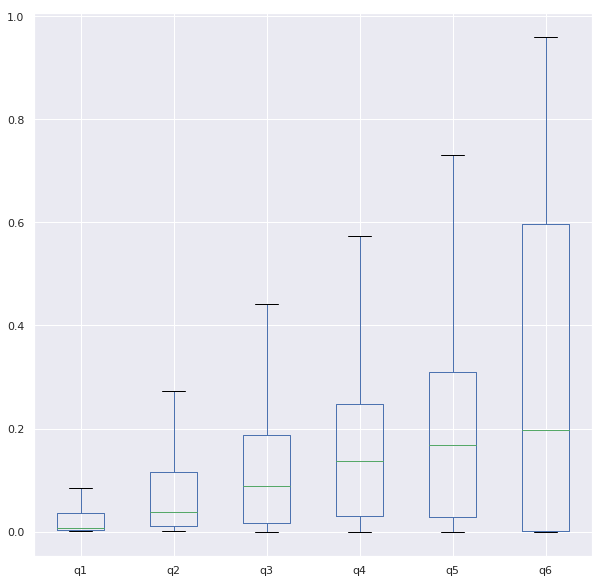

In [41]:
print_s3("Leyo test","s3://fda-labs/ltv-ml/lgbm_embedding/log.txt") 

s3 = boto3.client('s3')
s3.download_file("fda-labs", "ltv-ml/lgbm_embedding/std.sav","std.sav")
stdc_trained = joblib.load("std.sav")
s3.download_file("fda-labs", "ltv-ml/lgbm_embedding/model.pkl","model.pkl")

X = stdc_trained.transform(summary_cal[train_cols]) 
#y = np_utils.to_categorical(encoder.transform(summary_cal.quintil_true))

model = pickle.load(open("model.pkl", 'rb')) # cargo el modelo porque el otro tiene la columna de rand

y_pred = model.predict_proba(X)
summary_cal[["q1","q2","q3","q4","q5","q6"]] = pd.DataFrame(y_pred)

print_s3("Aplico sobre test","s3://fda-labs/ltv-ml/lgbm_embedding/log.txt")  

apply_me = summary_cal
sns.set(font_scale = 1)
apply_me[["q1","q2","q3","q4","q5","q6"]].boxplot(showfliers = False,figsize=(10,10))
plt.savefig("probas_distribution.png")

s3 = boto3.client('s3')
s3.upload_file("probas_distribution.png", "fda-labs", "ltv-ml/lgbm_embedding/probas_distribution.png")

In [42]:
def asigno_quintiles_1(x,step,q):    
    step2 = x.shape[0] - (step)
    l_ = ["q"+q]*step + ["non_q"]*step2
    return l_ 

apply_me["pred_q"] = "non_q"
resu = pd.DataFrame([])
step1 = int(apply_me.shape[0]*0.1)
step2 = int(apply_me.shape[0]*0.5)

for i in range(4):
    df = apply_me.loc[apply_me.pred_q == "non_q"]
    df = df.sort_values(by = "q"+str(i+1),ascending = False)
    df["pred_q"] = asigno_quintiles_1(df,step1,str(i+1))
    df = df.loc[df.pred_q != "non_q"]
    apply_me.loc[apply_me.cust.isin(df.cust.values),"pred_q"] = "q"+str(i+1)

df = apply_me.loc[apply_me.pred_q == "non_q"]
df = df.sort_values(by = "q6",ascending = False)
df["pred_q"] = asigno_quintiles_1(df,step2,"6")
df = df.loc[df.pred_q != "non_q"]
apply_me.loc[apply_me.cust.isin(df.cust.values),"pred_q"] = "q6"

apply_me.loc[apply_me.pred_q == "non_q","pred_q"] = "q5"

apply_me = apply_me.sort_values(by = "target_pareto",ascending = False)
apply_me["pareto_q"] = asigno_quintiles_6(apply_me)

In [47]:
l_ = []
for i in range(6):
    aux = apply_me.loc[apply_me["quintil_true"] == "q"+str(i+1)]
    aux2 = aux.loc[aux["pred_q"] == "q"+str(i+1)]
    l_.append({"q":"q"+str(i+1), "recall": aux2.shape[0]/aux.shape[0]})
    
fscore = f1_score(apply_me["quintil_true"],apply_me["pred_q"],average = "weighted")
l_.append({"q":"Fscore", "recall": fscore})
_write_dataframe_to_csv_on_s3(pd.DataFrame(l_),"s3://fda-labs/ltv-ml/lgbm_embedding/final_performance.csv")

In [44]:
confusion = confusion_matrix(apply_me["quintil_true"],apply_me["pred_q"])
for i in range(confusion.shape[0]):
    confusion[i,:] = 100*confusion[i,:]/confusion.sum(axis = 1)[i]

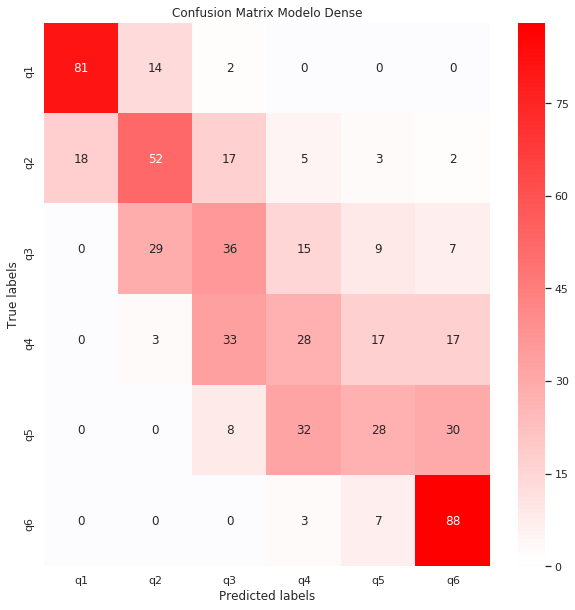

In [45]:
labels = ['q1', 'q2','q3','q4','q5','q6']
plt.figure(figsize=(10,10))
sns.set(font_scale = 1)
ax= plt.subplot()
sns.heatmap(confusion,annot = True,center = 1,ax=ax,cmap='bwr')
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix Modelo Dense'); 
ax.xaxis.set_ticklabels(labels); ax.yaxis.set_ticklabels(labels);

plt.savefig("confusion_matrix.png")

s3 = boto3.client('s3')
s3.upload_file("confusion_matrix.png", "fda-labs", "ltv-ml/lgbm_embedding/confusion_matrix.png")

In [ ]:
#jupyter nbconvert --to script ./training/train.ipynb